## Initial setup and downloading the data

In [2]:
! pip install kaggle

In [ ]:
! kaggle datasets download -d salviohexia/isic-2019-skin-lesion-images-for-classification

In [4]:
! mkdir skin_lesion_data

In [8]:
! unzip /home/mila/s/subhrajyoti.dasgupta/skin_lesion/isic-2019-skin-lesion-images-for-classification.zip -d skin_lesion_data

Archive:  /home/mila/s/subhrajyoti.dasgupta/skin_lesion/isic-2019-skin-lesion-images-for-classification.zip
  inflating: skin_lesion_data/AK/ISIC_0024468.jpg  
  inflating: skin_lesion_data/AK/ISIC_0024470.jpg  
  inflating: skin_lesion_data/AK/ISIC_0024511.jpg  
  inflating: skin_lesion_data/AK/ISIC_0024646.jpg  
  inflating: skin_lesion_data/AK/ISIC_0024654.jpg  
  inflating: skin_lesion_data/AK/ISIC_0024707.jpg  
  inflating: skin_lesion_data/AK/ISIC_0024763.jpg  
  inflating: skin_lesion_data/AK/ISIC_0024771.jpg  
  inflating: skin_lesion_data/AK/ISIC_0024800.jpg  
  inflating: skin_lesion_data/AK/ISIC_0024913.jpg  
  inflating: skin_lesion_data/AK/ISIC_0024948.jpg  
  inflating: skin_lesion_data/AK/ISIC_0025368.jpg  
  inflating: skin_lesion_data/AK/ISIC_0025427.jpg  
  inflating: skin_lesion_data/AK/ISIC_0025605.jpg  
  inflating: skin_lesion_data/AK/ISIC_0025780.jpg  
  inflating: skin_lesion_data/AK/ISIC_0025803.jpg  
  inflating: skin_lesion_data/AK/ISIC_0025825.jpg  
  inflat

## Loading the required libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import random

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader, random_split

from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import pandas as pd

## Data Exploration

In [2]:
PATH_TO_DIR = 'skin_lesion_data/'

skin_lesion_data/MEL/ISIC_0072375.jpg


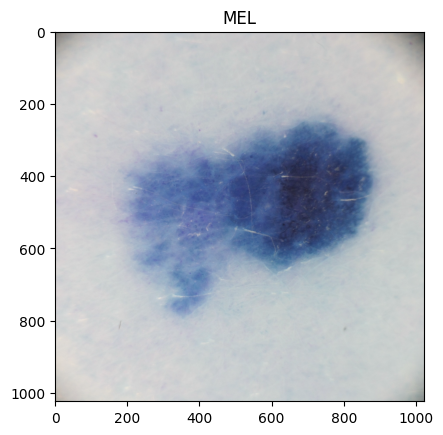

skin_lesion_data/SCC/ISIC_0025577.jpg


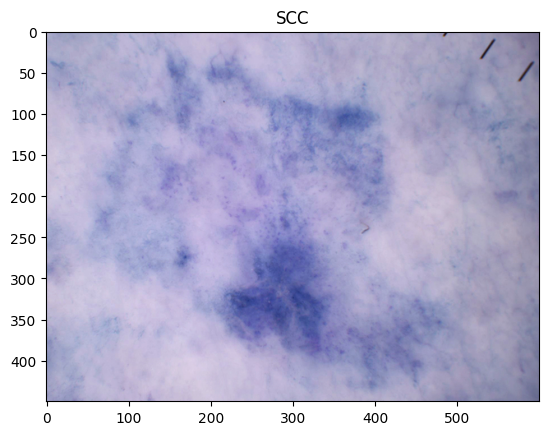

skin_lesion_data/VASC/ISIC_0061280.jpg


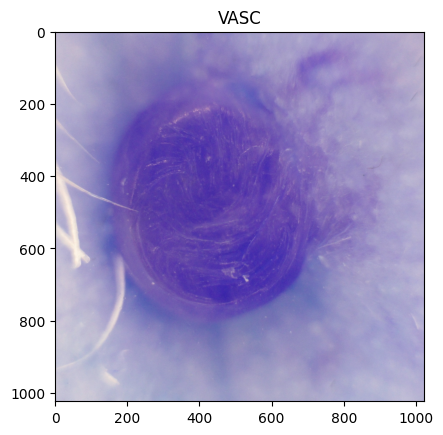

skin_lesion_data/AK/ISIC_0061691.jpg


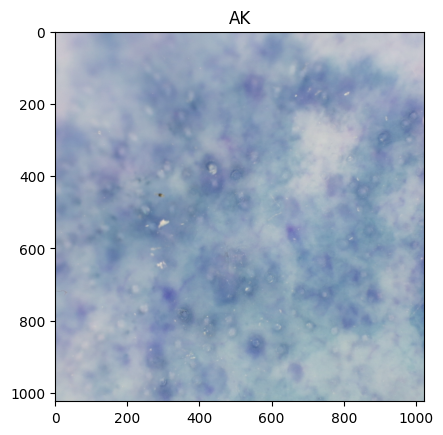

skin_lesion_data/NV/ISIC_0030880.jpg


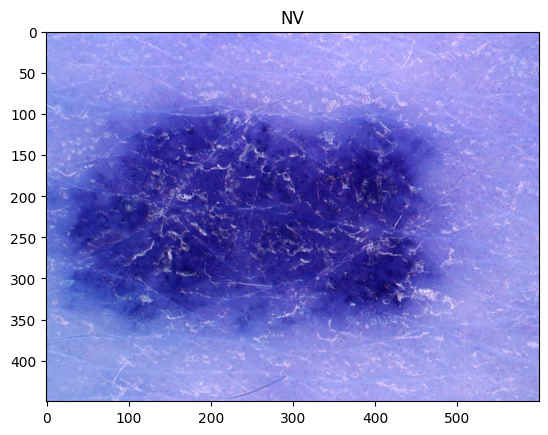

skin_lesion_data/BKL/ISIC_0013160_downsampled.jpg


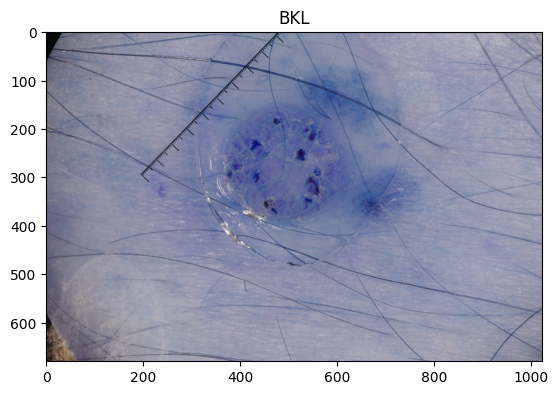

skin_lesion_data/DF/ISIC_0033422.jpg


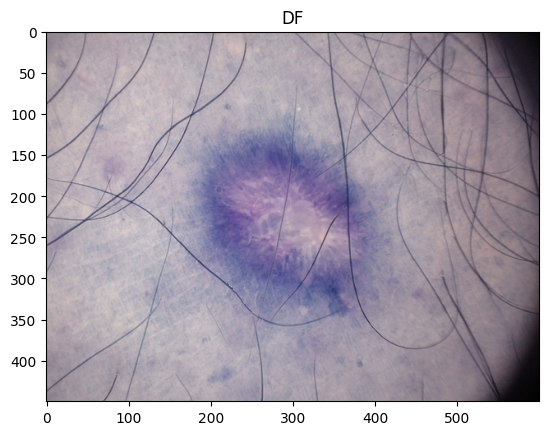

skin_lesion_data/BCC/ISIC_0059854.jpg


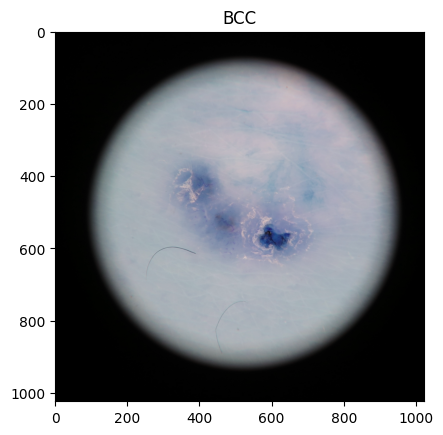

In [3]:
for dir in os.listdir(PATH_TO_DIR):
  if dir[-3:] != 'csv':
    for img in os.listdir(PATH_TO_DIR + dir):
      print(PATH_TO_DIR + dir + '/' + img)
      image = cv2.imread(PATH_TO_DIR + dir + '/' + img)
      plt.imshow(image)
      plt.title(dir)
      break
    plt.show()

[(4522, 'MEL'), (628, 'SCC'), (253, 'VASC'), (867, 'AK'), (12875, 'NV'), (2624, 'BKL'), (239, 'DF'), (3323, 'BCC')]


<BarContainer object of 8 artists>

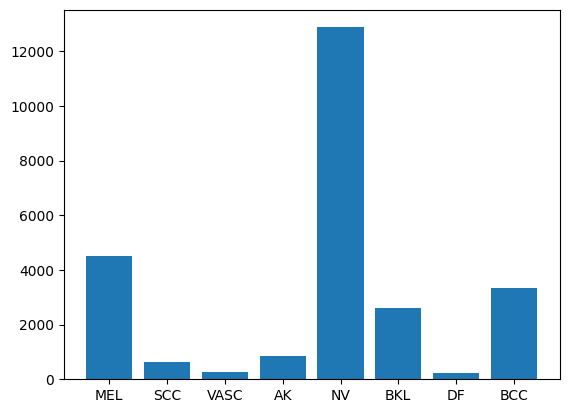

In [4]:
freq = [(len(os.listdir(PATH_TO_DIR + dir)), dir) \
        for dir in os.listdir(PATH_TO_DIR) \
        if dir[-3:] != 'csv']
print(freq)
plt.bar([f[1] for f in freq], [f[0] for f in freq])

## Defining transformations and setting up the Data Loaders

In [3]:
# transform the image size to 255 by 255 and then center crop
transform = transforms.Compose([
      transforms.Resize(255),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize([0.485, 0.456, 0.406],
                           [0.229, 0.224, 0.225])])

# load train/valid/test set using ImageFolder 
dataset = datasets.ImageFolder(root=PATH_TO_DIR, transform=transform)

# Split the dataset into train, validation, and test sets
total_size = len(dataset)
train_size = int(0.9 * total_size)  # 90% for training
val_size = int(0.05 * total_size)  # 5% for validation
test_size = total_size - train_size - val_size  # Remaining 5% for testing

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

# Create data loaders for train, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [10]:
len(train_dataset)

22797

## Loading the pre-trained model

- We are using the pre-trained VGG-16 model here mainly because of the comparatively lesser complexity it has. It is very widely used as a feature extractor and using a more complex model in such an imbalance setting may lead to overfitting.

In [11]:
# Load pretrained VGG16 model
vgg16 = models.vgg16(pretrained=True)

# Freeze convolutional layers to keep the pretrained weights
for param in vgg16.features.parameters():
    param.requires_grad = False

# Modify the classifier to match the number of classes in your dataset
num_classes = len(dataset.classes)
vgg16.classifier[-1] = nn.Linear(vgg16.classifier[-1].in_features, num_classes)

# Define loss criterion and optimizer
criterion = nn.CrossEntropyLoss()
# specify optimizer (stochastic gradient descent) and learning rate
optimizer = optim.Adam(vgg16.parameters(), lr=1e-5)

In [12]:
print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Finetuning the model on our dataset

In [8]:
# Train the model
num_epochs = 5
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg16.to(device)

for epoch in range(num_epochs):
    vgg16.train()
    running_loss = 0.0
    # count = 0
    for inputs, labels in train_loader:
        # if count > 2:
        #   break
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg16(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        # count+=1
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader)}")

Epoch 1/5, Loss: 1.152760265084169
Epoch 2/5, Loss: 0.9427370714940664
Epoch 3/5, Loss: 0.8301929310277668
Epoch 4/5, Loss: 0.7293383351632957
Epoch 5/5, Loss: 0.6363114020767586


In [5]:
PATH = '/home/mila/s/subhrajyoti.dasgupta/skin_lesion/models/'

### Saving the model

In [10]:
if not os.path.exists(PATH + 'multiclass/'):
    os.mkdir(PATH + 'multiclass/')
    
torch.save(vgg16, PATH + 'multiclass/vgg16_finetuned_multiclass.PTH')

### Loading the saved model

In [6]:
vgg16 = torch.load(PATH + 'multiclass/vgg16_finetuned_multiclass.PTH')

### Model Evaluation

In [21]:
# Testing
correct = 0
total = 0
y_predicted = []
y_label = []
with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = vgg16(inputs)
        _, predicted = torch.max(outputs.data, 1)
        # predicted.append(torch.max(outputs.data, 1)[1])
        total += labels.size(0)
        # print(total)
        correct += (predicted == labels).sum().item()
        y_predicted.extend(predicted.cpu().numpy())
        y_label.extend(labels.cpu().numpy())

Test Accuracy: 79.65299684542586%

############ CLASSIFICATION REPORT ############
              precision    recall  f1-score   support

           0       0.62      0.31      0.41        42
           1       0.68      0.84      0.76       152
           2       0.75      0.57      0.65       141
           3       0.00      0.00      0.00        12
           4       0.78      0.66      0.72       233
           5       0.84      0.95      0.89       655
           6       0.73      0.33      0.46        24
           7       0.80      0.44      0.57         9

    accuracy                           0.80      1268
   macro avg       0.65      0.51      0.56      1268
weighted avg       0.78      0.80      0.78      1268



/home/mila/s/subhrajyoti.dasgupta/.conda/envs/quick_recipe/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mila/s/subhrajyoti.dasgupta/.conda/envs/quick_recipe/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/mila/s/subhrajyoti.dasgupta/.conda/envs/quick_recipe/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to c

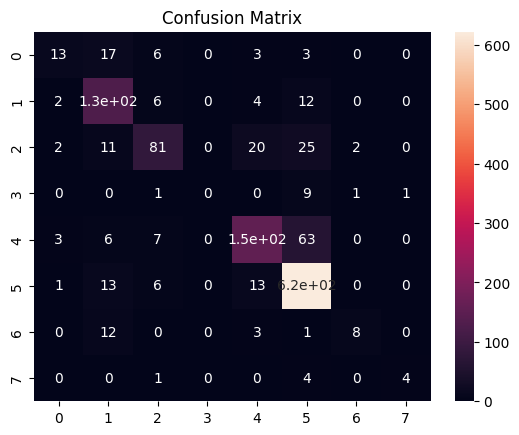

In [23]:
print(f"Test Accuracy: {100 * correct / total}%\n")

print('############ CLASSIFICATION REPORT ############')
print(classification_report(y_label,y_predicted))


confusion_matrix_df = pd.DataFrame(confusion_matrix(y_label, y_predicted))
ax = plt.axes()
sns.heatmap(confusion_matrix_df, annot=True, ax=ax)
ax.set_title('Confusion Matrix')
plt.show()

### Discussion

We find that the model gets a decent accuracy of 80%. However, some of the minority classes have not performed well. Here, techniques like oversampling the minority classes, using synthetic data or distributing the dataset into a more balanced one can help.

## Explainability
We explore here the explainability of the CNN model here. 
1. We plot one of the intermediate layer's feature maps
2. Taking a closer look, we find the model is taking a look at the highlighted regions when making a prediction on a given image.

### Checking all the key names of the VGG layers

In [7]:
print(vgg16.state_dict().keys())

odict_keys(['features.0.weight', 'features.0.bias', 'features.2.weight', 'features.2.bias', 'features.5.weight', 'features.5.bias', 'features.7.weight', 'features.7.bias', 'features.10.weight', 'features.10.bias', 'features.12.weight', 'features.12.bias', 'features.14.weight', 'features.14.bias', 'features.17.weight', 'features.17.bias', 'features.19.weight', 'features.19.bias', 'features.21.weight', 'features.21.bias', 'features.24.weight', 'features.24.bias', 'features.26.weight', 'features.26.bias', 'features.28.weight', 'features.28.bias', 'classifier.0.weight', 'classifier.0.bias', 'classifier.3.weight', 'classifier.3.bias', 'classifier.6.weight', 'classifier.6.bias'])


### Selecting the layer number

In [19]:
layer_num = 24

layer = vgg16.features[layer_num]
print(layer)

Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))


### Setting up the hook

In [20]:
# Hook function
def hook_fn(module, input, output):
    global layer_output
    layer_output = output

# Register the hook
handle = layer.register_forward_hook(hook_fn)

### Fetching the intermediate feature maps

In [21]:
inputs, _ = next(iter(test_loader))

In [22]:
img = inputs.to(device)

# Forward pass the image through the model
vgg16.eval()

with torch.inference_mode():
    preds = vgg16(img)

layer_output = layer_output.squeeze()

In [25]:
layer_output.size()

torch.Size([32, 512, 14, 14])

### Plotting the feature maps

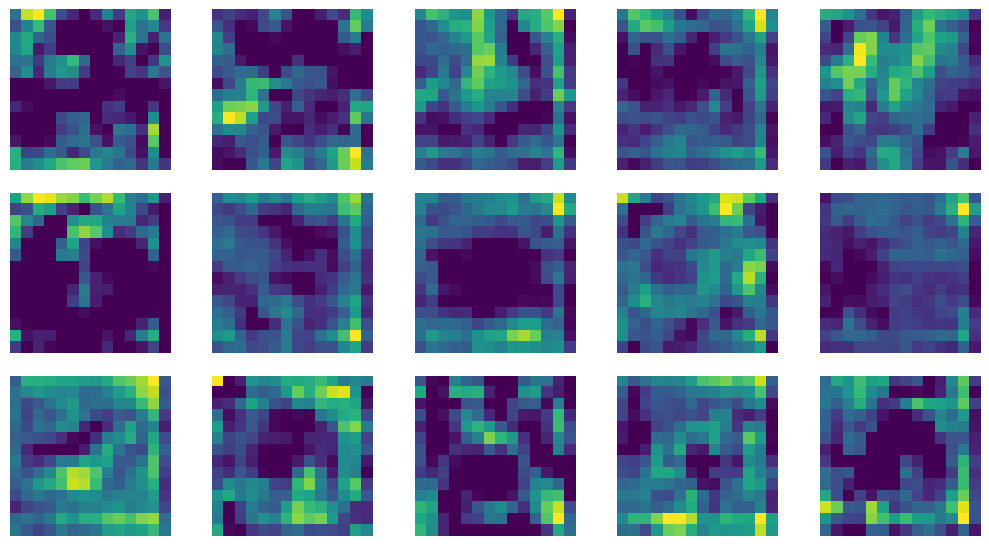

In [24]:
import matplotlib.pyplot as plt

rows, cols = 3, 5

fig = plt.figure(figsize=(10, 6))

for i in range(1, (rows * cols) + 1):
    feature_map = layer_output[i-1, :, :].cpu().numpy()
    fig.add_subplot(rows, cols, i)
    plt.imshow(feature_map[0], cmap='viridis')
    plt.tight_layout()
    plt.axis(False)

### Using SHAP to explain model predictions

In [38]:
import shap

batch = next(iter(test_loader))
images, _ = batch
# images = images.view(-1, 1, 28, 28)

background = images[:10]
test_images= images[10:15]

e = shap.DeepExplainer(vgg16, images.to(device))
shap_values = e.shap_values(test_images, )

Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


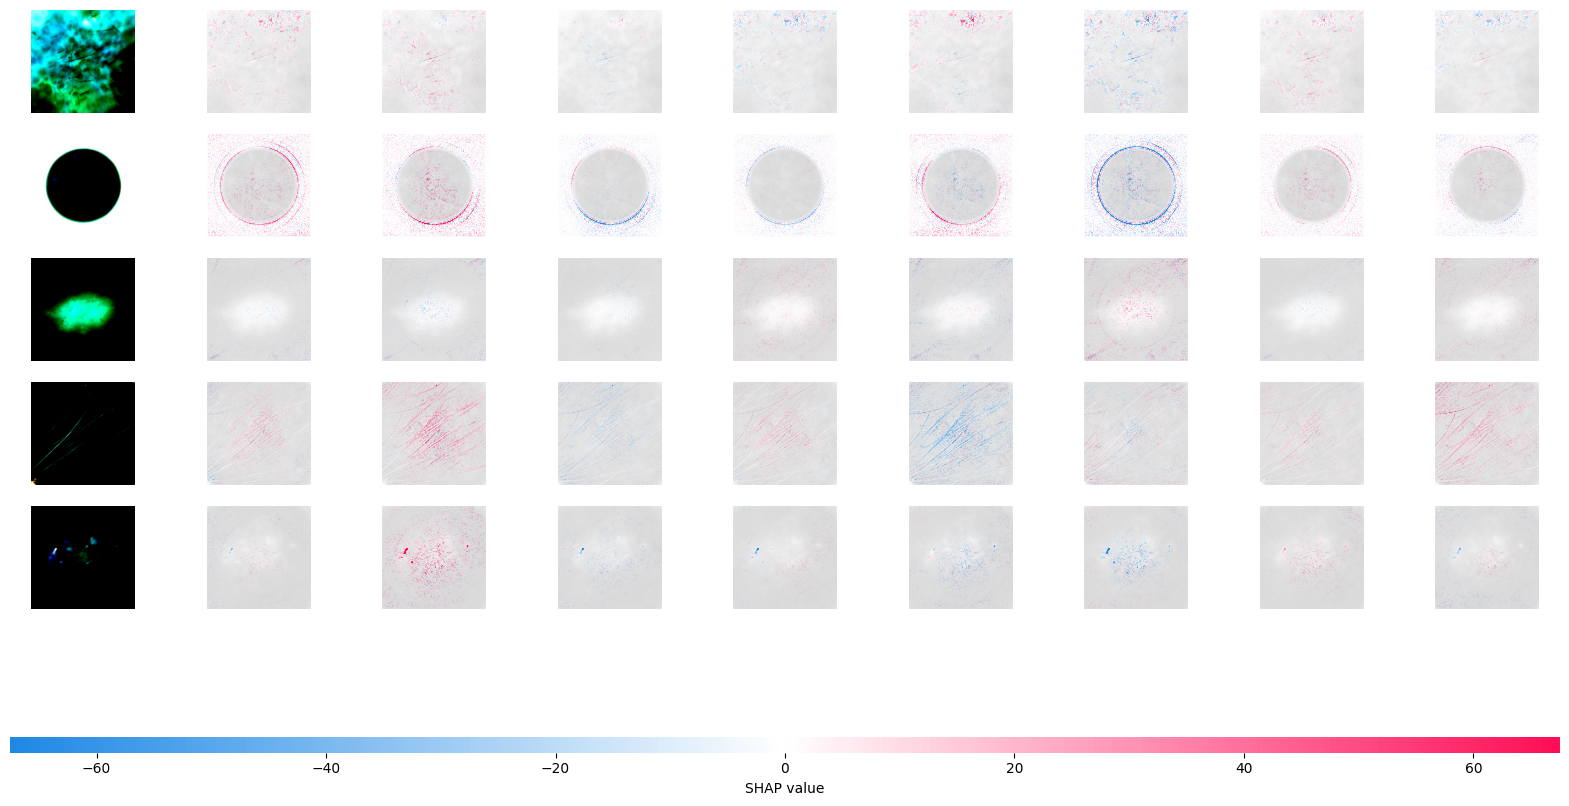

In [39]:
shap_numpy = [np.swapaxes(np.swapaxes(s, 1, -1), 1, 2) for s in shap_values]
test_numpy = np.swapaxes(np.swapaxes(test_images.numpy(), 1, -1), 1, 2)

shap.image_plot(shap_numpy, -test_numpy)